#PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts

https://arxiv.org/abs/1710.06071

Please go through the above paper.
This project is implementing  on this paper.
This is many to one problem.


The data Sets: is from PUbMEd 200k RCT.

The model comes from the below link :https://arxiv.org/pdf/1612.05251.pdf

In [2]:
!nvidia-smi

Sun Jan 14 11:23:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

we can get the dataset from the GIthubs of the authors:https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 26.75 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [4]:
!ls pubmed-rct/

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [5]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [6]:
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.zip


train.txt - training samples.


dev.txt - dev is short for development set, which is another name for validation set (in our case, we'll be using and referring to this file as our validation set).


test.txt - test samples.

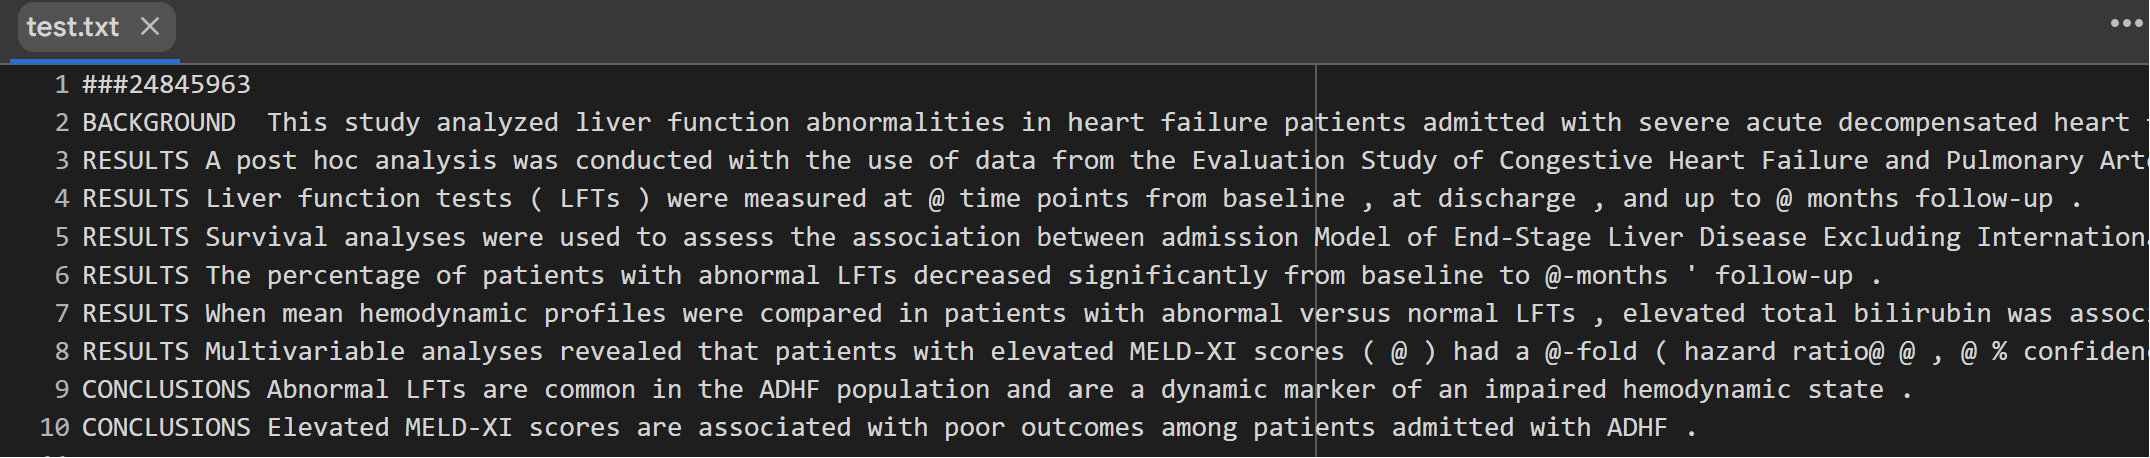

In [7]:
data = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [8]:
import os
filenames = [data + i for i in os.listdir(data)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [9]:
#visulising the datset to understand
import pandas as pd
#data_train = pd.read_csv('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')""" #this is not working as its a text data

#Preprocessing The Data

In [10]:
#Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()


In [11]:
train_lines = get_lines(data+"train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

bove we can see that each individuak abstarct starts from '##' and then it is labeled as OBJECTIVE ,METHODS,RESULTs,CONclusion so next our target is to separate each abstract as well as separaete each labels so for that we have to create a function for the same.



---



---



[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]

In [12]:
#This is the code cretaed by Daniel

''''def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

return abstract_samples'''

'\'def preprocess_text_with_line_numbers(filename):\n  """Returns a list of dictionaries of abstract line data.\n\n  Takes in filename, reads its contents and sorts through each line,\n  extracting things like the target label, the text of the sentence,\n  how many sentences are in the current abstract and what sentence number\n  the target line is.\n\n  Args:\n      filename: a string of the target text file to read and extract line data\n      from.\n\n  Returns:\n      A list of dictionaries each containing a line from an abstract,\n      the lines label, the lines position in the abstract and the total number\n      of lines in the abstract where the line is from. For example:\n\n      [{"target": \'CONCLUSION\',\n        "text": The study couldn\'t have gone better, turns out people are kinder than you think",\n        "line_number": 8,\n        "total_lines": 8}]\n  """\n  input_lines = get_lines(filename) # get all lines from filename\n  abstract_lines = "" # create an empty abs

In [13]:
#this code is mine with the same purpose

def preprocess_text_with_line_numbers(filename):
    abstract_samples = []



    input_lines = get_lines(filename)
    abstract_lines = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_lines = []
        elif line.isspace():
            for i, abstract_line in enumerate(abstract_lines):
                target, text = abstract_line.split("\t", 1)
                abstract_samples.append({
                    "target": target,
                    "text": text.lower(),
                    "line_number": i,
                    "total_lines": len(abstract_lines)
                })
        else:
            abstract_lines.append(line.strip())

    return abstract_samples


# Loop through each line in the input file
    for line in input_lines:
        # Check if the line is the start of a new abstract
        if line.startswith("###"):
            abstract_lines = []  # Reset the list for a new abstract
        # Check if the line is a blank line, indicating the end of an abstract
        elif line.isspace():
            # Iterate through each line in the abstract and extract information
            for i, abstract_line in enumerate(abstract_lines):
                # Split the line into target label and text
                target, text = abstract_line.split("\t", 1)
                # Add information to the list of abstract samples
                abstract_samples.append({
                    "target": target,
                    "text": text.lower(),
                    "line_number": i,
                    "total_lines": len(abstract_lines)
                })
        else:
            # If the line is not a new abstract or a blank line, add it to the current abstract
            abstract_lines.append(line.strip())

In [14]:
train_samples = preprocess_text_with_line_numbers(data + "train.txt")
val_samples = preprocess_text_with_line_numbers(data + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [15]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [16]:
#we will turn the data into datframe so that we can preprocess it
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,12
180036,RESULTS,"for pav , a significantly greater percentage o...",8,12
180037,RESULTS,both strategies had acceptable side effect pro...,9,12
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,12


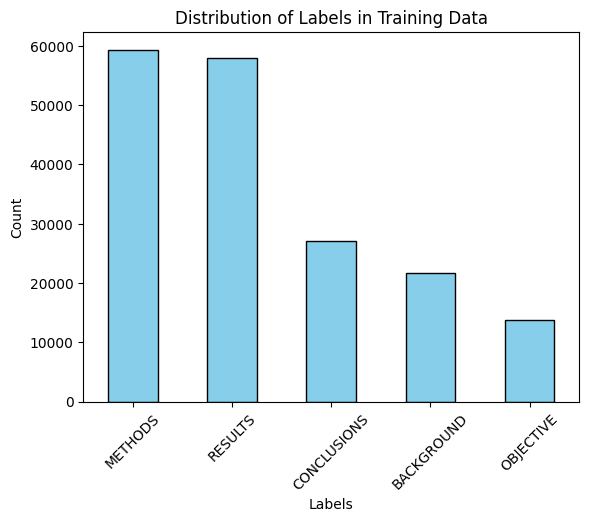

In [17]:
import matplotlib.pyplot as plt

# Plotting value counts for the 'label' column
label_counts = train_df.target.value_counts()

# Plotting
label_counts.plot(kind='bar', rot=45, color='skyblue', edgecolor='black')
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()


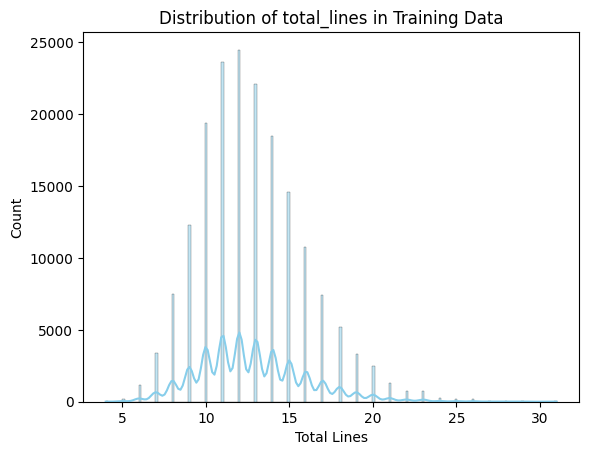

In [18]:
import seaborn as sns

sns.histplot(train_df['total_lines'], kde=True, color='skyblue')
plt.title('Distribution of total_lines in Training Data')
plt.xlabel('Total Lines')
plt.ylabel('Count')
plt.show()

In [19]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

Same one_hot _encoder is used for train.test and valid data

In [20]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names


(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

#creating a baseline model as usual

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

TF-IDF Vectorizer (TfidfVectorizer):

The TfidfVectorizer is a feature extraction technique widely used in natural language processing (NLP) and text mining.
It converts a collection of raw documents (text) into a matrix of TF-IDF features.
TF-IDF reflects the importance of a word in a document relative to its frequency across a collection of documents.
The parameters of the TfidfVectorizer can be adjusted based on specific requirements, such as the choice of n-grams, stop words, etc.
Multinomial Naive Bayes Classifier (MultinomialNB):

The MultinomialNB classifier is a variant of the Naive Bayes algorithm designed for classification tasks, especially when the features are discrete.
It's commonly used for text classification problems, making it a suitable choice after TF-IDF vectorization.
The model assumes that the features are independent given the class, hence the "naive" in Naive Bayes.
Pipeline:

The Pipeline class in scikit-learn allows you to define a sequence of transformations and a final estimator.
In this case, the pipeline consists of a TF-IDF vectorizer followed by a Multinomial Naive Bayes classifier.
This makes it easier to encapsulate the entire workflow into a single object, facilitating training and evaluation.

In [24]:
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

In [25]:
#Fit
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [26]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [27]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [28]:
!wget !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-14 11:23:26--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2024-01-14 11:23:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-01-14 11:23:26 (12.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]

FINISHED --2024-01-14 11:23:26--
Total wall clock time: 0.2s
Downloaded: 1 files, 10K in 0.001s (12.9 MB/s)


In [29]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [30]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

#Create now word embedding or vectorization

For this we text vectorization from tensor flow and want to see, for max tokenisation is the maximum vocabluary included in the text so we can refer back the paper for this ti see the PubMed.

In [31]:
import numpy as np
length_of_sentence =[len(sentence.split()) for sentence in train_sentences]
np.mean(length_of_sentence)

26.338269273494777

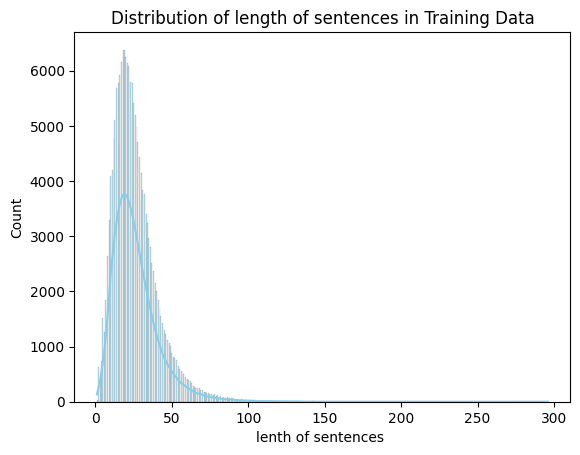

In [32]:
sns.histplot(length_of_sentence, kde=True, color='skyblue')
plt.title('Distribution of length of sentences in Training Data')
plt.xlabel('lenth of sentences ')
plt.ylabel('Count')
plt.show()

we want to see what percerntage covers maximum sentences  as we want to involve most of the sentences.

In [33]:
output_sequence_length = int(np.percentile(length_of_sentence,95))
output_sequence_length

55

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.

In [34]:
max_tokens = 68000

In [35]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_sequence_length)

.adapt(train_sentences):

The adapt method is often used in the context of TensorFlow's TextVectorization layer or a similar layer in another deep learning library.
It means adjusting the internal parameters of the text vectorizer based on the provided training data (train_sentences in this case).
This adaptation process may involve learning vocabulary, tokenization rules, or other configuration settings from the training dat

In [36]:
text_vectorizer.adapt(train_sentences)

In [37]:
import random
target_sentence = random.choice(train_sentences)
print('Text',target_sentence)
print('len:', len(target_sentence.split()))
print('Vectorisation of the above sentnece', text_vectorizer([target_sentence]))

Text pilot randomized controlled trial .
len: 5
Vectorisation of the above sentnece tf.Tensor(
[[689  29 106  32   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]], shape=(1, 55), dtype=int64)



In the context of TensorFlow and Keras, the get_config() method is used to retrieve the configuration of a Keras layer or model. Specifically, it returns a dictionary containing the configuration information of the layer or model, which includes the parameters used during its construction.

In [38]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [39]:
len(text_vectorizer.get_vocabulary())

64841

#Embedding:
to capture the reltionshipbteween the words



Setting mask_zero=True when creating an Embedding layer in TensorFlow has the advantage of allowing the layer to handle padding in input sequences more effectively, especially when working with sequences of varying lengths. This is particularly relevant in natural language processing (NLP) tasks where sentences or sequences may have different lengths, and padding is often used to make them uniform.

Here are the key advantages:

Padding Handling:

When sequences are padded with zeros to achieve uniform length, it's common to want the neural network to ignore the padded values during training. Setting mask_zero=True achieves this by masking out the embeddings corresponding to the padded zeros.
Masking prevents the network from considering padding as meaningful input, which can be crucial for tasks like sequence classification or language modeling.
Efficient Processing:

Masking zeros can lead to more efficient processing during training and inference. It allows the network to focus only on the actual elements of the sequence, ignoring the padding, which can reduce computational overhead.
Dynamic Sequence Lengths:

When working with sequences of varying lengths, such as in tasks involving sentences or documents, setting mask_zero=True enables the model to handle variable-length sequences more gracefully.
During training, the model can process sequences of different lengths in a single batch without being constrained by a fixed sequence length.

In [40]:
import tensorflow as tf

In [41]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()), # set input shape
                             output_dim=128, # set size of embedding vector
                             #embeddings_initializer="uniform", # default, intialize randomly
                             mask_zero = True, #will do masking to make it more efficent
                             #input_length=max_length, # how long is each input
                             name="embedding"
                             )

embedding

we see below how a sentce is been converted to token and then to embedding

In [42]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
pilot randomized controlled trial .

Sentence after vectorization (before embedding):
[[689  29 106  32   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

Sentence after embedding:
[[[ 0.01318914  0.00832912 -0.02508305 ...  0.03344851 -0.03840268
    0.02474974]
  [-0.04072488 -0.0099433  -0.03993927 ... -0.01203495  0.04359338
   -0.03614037]
  [-0.03766171 -0.04799602  0.00914595 ...  0.02199162 -0.0126496
   -0.00124166]
  ...
  [-0.0067323   0.01050667  0.02847851 ...  0.03574464  0.01269234
   -0.00079899]
  [-0.0067323   0.01050667  0.02847851 ...  0.03574464  0.01269234
   -0.00079899]
  [-0.0067323   0.01050667  0.02847851 ...  0.03574464  0.01269234
   -0.00079899]]]

Embedded sentence shape: (1, 55, 128)


#Want to make the data load faster with help of tf.data API

https://www.tensorflow.org/guide/data

https://www.tensorflow.org/guide/data_performance

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot)):

train_sentences likely contains the input data (e.g., sentences or text), and train_labels_one_hot contains the corresponding one-hot encoded labels.
tf.data.Dataset.from_tensor_slices is a method that creates a dataset whose elements are slices of the given tensors (in this case, pairs of input sentences and one-hot encoded labels).
This dataset is suitable for training a machine learning model, where each element consists of an input sample and its corresponding label.

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [44]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [45]:
valid_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [46]:
test_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE):

train_dataset.batch(32) creates batches of size 32 from the individual samples in the training dataset.
train_dataset.prefetch(tf.data.AUTOTUNE) prefetches the next batch of data, asynchronously loading it in the background while the current batch is being processed.
The combination of batching and prefetching helps to improve training efficiency by processing multiple samples in parallel and reducing potential data loading bottlenecks.

In [47]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [48]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#CONV NN 1D
here we are using the text vectorisation and embedding (token) that we have created before.

In [49]:
num_classes

5

In [50]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # 1 sequence at a time that why sahpe = (1,)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x) # first conv1d layer , kernal = 5 means it will look 5 words at a time
x = layers.GlobalAveragePooling1D()(x) #used average pooling
outputs = layers.Dense(5, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1D")

# Compile Conv1D model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_1.summary()

Model: "model_1_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 51, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)              

Since our training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we're going to run them on a subset of the training dataset.

More specifically, we'll only use the first 10% of batches (about 18,000 samples) of the training

In [51]:
#fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 20s 30ms/step - loss: 0.9603 - accuracy: 0.6128 - val_loss: 0.7308 - val_accuracy: 0.7221
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6831 - accuracy: 0.7462 - val_loss: 0.6585 - val_accuracy: 0.7630
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.6366 - accuracy: 0.7676 - val_loss: 0.6182 - val_accuracy: 0.7729


In [52]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6159 - accuracy: 0.7796


[0.6158964037895203, 0.7795577645301819]

In [53]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
print(model_1_pred_probs)
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
print(model_1_preds)

945/945 [==============================] - 3s 3ms/step
[[4.5084158e-01 1.3980560e-01 7.8588560e-02 3.0693573e-01 2.3828549e-02]
 [4.5099932e-01 2.0372455e-01 1.8098926e-02 3.1645191e-01 1.0725196e-02]
 [1.9215563e-01 2.9298458e-02 2.2749586e-03 7.7609539e-01 1.7562133e-04]
 ...
 [7.4936706e-06 8.0119056e-04 4.2207475e-04 5.4239808e-06 9.9876380e-01]
 [5.3480949e-02 3.5964575e-01 1.5412134e-01 7.1274944e-02 3.6147702e-01]
 [2.4678580e-01 5.6227142e-01 1.0018812e-01 5.3014752e-02 3.7739918e-02]]
tf.Tensor([0 0 3 ... 4 4 1], shape=(30212,), dtype=int64)


In [54]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 4, 2, 4, 2, 4, 1])>

In [55]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.95577916059844,
 'precision': 0.7760299586924713,
 'recall': 0.7795577916059844,
 'f1': 0.7766485534148004}

#transfer learning
as we go through the paper we can see that the papers have used tranfer learning or pretrained embedding and they using GLoVe which came out in the year 2014.
this is our Model 2  

##Model 2: Featrure extraction with pretrained embedding

we are using the univeral sentence encoder(USE) for pretrained embedding

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)

In [56]:

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [57]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
pulsed radiofrequency ( prf ) allows heat dissipation , thus producing a temporary injury that affects only type c fibers responsible for pain conduction .

Sentence after embedding:
[ 0.00461466  0.05412155 -0.03834624 -0.03850948  0.00109318 -0.00247835
  0.02521959 -0.03816577  0.04523911  0.04320862  0.04588748 -0.08086787
  0.0545797   0.02083808  0.05455086 -0.06614013 -0.01156206  0.06490398
  0.01470618 -0.05666042 -0.07031524  0.0496782   0.03499363 -0.01391284
  0.04088971 -0.00809202  0.04166833 -0.06680799 -0.00156038 -0.02799797] (truncated output)...

Length of sentence embedding:
512


Now using this USE encoder we are going to tain according to the folowing

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)


In [58]:
inputs = layers.Input(shape=[], dtype=tf.string) #input is alway list that why shape = [] empty list
pretrained_embedding= tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE")

# Compile Conv1D model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [59]:
#fit the model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 12ms/step - loss: 0.9160 - accuracy: 0.6537 - val_loss: 0.7950 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7681 - accuracy: 0.7022 - val_loss: 0.7547 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7514 - accuracy: 0.7128 - val_loss: 0.7394 - val_accuracy: 0.7131


In [60]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7409 - accuracy: 0.7146


[0.7409113049507141, 0.7146167159080505]

In [61]:
model_2_pred_probs = model_2.predict(valid_dataset)
#print(model_2_pred_probs)
# Convert pred probs to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
#print(model_2_preds)

945/945 [==============================] - 10s 10ms/step


In [62]:
# Calculate model_2 results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.46167085926122,
 'precision': 0.714694759834626,
 'recall': 0.7146167085926122,
 'f1': 0.7114540946776351}

#Model 3: Conv1D with character embeddings



---



the paper we are using have token and charachter level embeedings, we have see token level emebeddingg but not charachter level embeddings:

Now what is Character embedding:
In simple words each character is embedded into numbers.

so now we have to prepare our data in charachter level as our data consist of words.


In [63]:
# function to create chracters from words
def split_chars(text):
  return " ".join(list(text))

In [64]:
split_chars('I love natural language processing')

'I   l o v e   n a t u r a l   l a n g u a g e   p r o c e s s i n g'

In [65]:
#now for all the train,val and test sentences
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [66]:
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

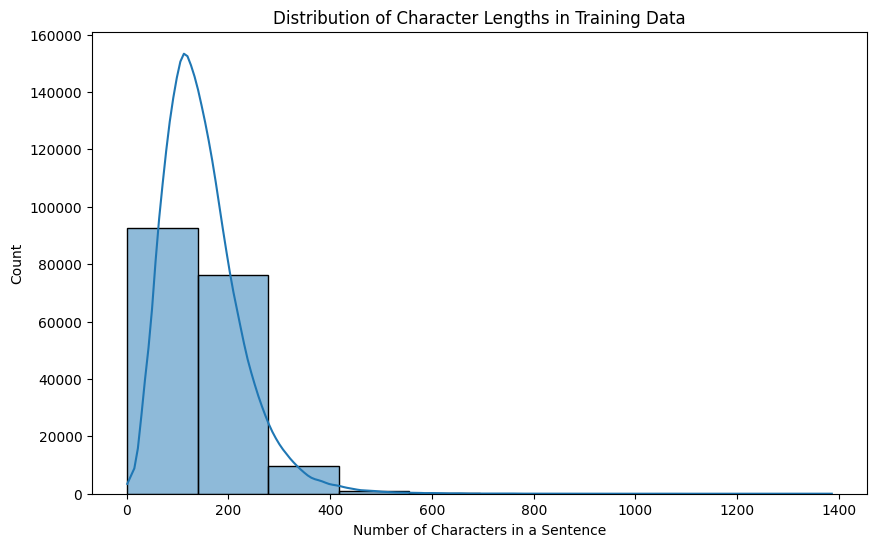

In [67]:
char_lens = [len(sentence_chars) for sentence_chars in train_sentences]

# Plot the histogram of character lengths
plt.figure(figsize=(10, 6))
sns.histplot(char_lens, bins=10, kde=True)
plt.title('Distribution of Character Lengths in Training Data')
plt.xlabel('Number of Characters in a Sentence')
plt.ylabel('Count')
plt.show()

In [68]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

We'll set max_tokens (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [69]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
num_char_tokens = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=num_char_tokens,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [71]:
len(char_vectorizer.get_vocabulary())

28

visuliising how a haracheter level data is beeing vectorized

In [72]:
random_train_chars = random.choice(train_chars)
print("Charified text",random_train_chars)
vectorized_chars = char_vectorizer([random_train_chars])
print("Vectorized chars",vectorized_chars)

Charified text b l o o d   s a m p l e s   w e r e   r a n d o m l y   c o l l e c t e d   f r o m   b l o o d   d o n o r s   i n   t h e   b l o o d   t r a n s f u s i o n   c e n t r e   o f   s o u s s e   (   t u n i s i a   )   .
Vectorized chars tf.Tensor(
[[22 12  7  7 10  9  5 15 14 12  2  9 20  2  8  2  8  5  6 10  7 15 12 19
  11  7 12 12  2 11  3  2 10 17  8  7 15 22 12  7  7 10 10  7  6  7  8  9
   4  6  3 13  2 22 12  7  7 10  3  8  5  6  9 17 16  9  4  7  6 11  2  6
   3  8  2  7 17  9  7 16  9  9  2  3 16  6  4  9  4  5  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

Now we have to create the charachter embedding.

The input dimension (input_dim) will be equal to the number of different characters in our char_vocab (28). And since we're following the structure of the model in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, the output dimension of the character embedding (output_dim) will be 25.

### Character embedding

In [73]:
char_embed = layers.Embedding(input_dim=num_char_tokens, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
b l o o d   s a m p l e s   w e r e   r a n d o m l y   c o l l e c t e d   f r o m   b l o o d   d o n o r s   i n   t h e   b l o o d   t r a n s f u s i o n   c e n t r e   o f   s o u s s e   (   t u n i s i a   )   .

Embedded chars (after vectorization and embedding):
[[[-0.03245214 -0.02452515 -0.01956403 ... -0.00675317 -0.03049264
    0.03804809]
  [ 0.02668264 -0.04993851 -0.04202757 ...  0.01295967 -0.03800453
    0.02758193]
  [-0.03494192 -0.00103091  0.04257653 ... -0.02059757  0.03430451
    0.03538391]
  ...
  [ 0.00861701 -0.00294437 -0.02299239 ...  0.01495438  0.03038507
   -0.00598638]
  [ 0.00861701 -0.00294437 -0.02299239 ...  0.01495438  0.03038507
   -0.00598638]
  [ 0.00861701 -0.00294437 -0.02299239 ...  0.01495438  0.03038507
   -0.00598638]]]

Character embedding shape: (1, 290, 25)


##Buliding a CONV 1D model using only and char emebdding train the mdoel

In [74]:
# Calculate average character length
total_chars = sum(len(sentence) for sentence in train_sentences)
total_sentences = len(train_sentences)
average_char_length = total_chars / total_sentences

print(f"Average Character Length: {average_char_length:.2f}")


Average Character Length: 149.37


In [75]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=150, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [76]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           240064    
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

Before fitting our model on the data, we'll create char-level batched PrefetchedDataset's.

In [77]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 9ms/step - loss: 1.2376 - accuracy: 0.4840 - val_loss: 1.0355 - val_accuracy: 0.5928
Epoch 2/3
562/562 [==============================] - 4s 8ms/step - loss: 0.9899 - accuracy: 0.6033 - val_loss: 0.9251 - val_accuracy: 0.6453
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9239 - accuracy: 0.6386 - val_loss: 0.8690 - val_accuracy: 0.6636


In [79]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8875 - accuracy: 0.6511


[0.8875240087509155, 0.6511319875717163]

In [80]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[0.26264143, 0.55350727, 0.02504297, 0.1470696 , 0.01173871],
       [0.08927527, 0.3678204 , 0.1690544 , 0.12578994, 0.24805996],
       [0.11851295, 0.01717549, 0.00529148, 0.8558178 , 0.00320234],
       ...,
       [0.0092498 , 0.08375499, 0.02903373, 0.00627288, 0.8716886 ],
       [0.08628987, 0.319782  , 0.04995696, 0.14872186, 0.39524937],
       [0.31907257, 0.570344  , 0.06947375, 0.03043802, 0.01067171]],
      dtype=float32)

In [81]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [82]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results


{'accuracy': 65.11320005295909,
 'precision': 0.6523210193167186,
 'recall': 0.6511320005295909,
 'f1': 0.6413677213566176}

#Combining pretrained token embeddings + character embeddings

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

 we have to built a model as show in the fig below (from the paper):
 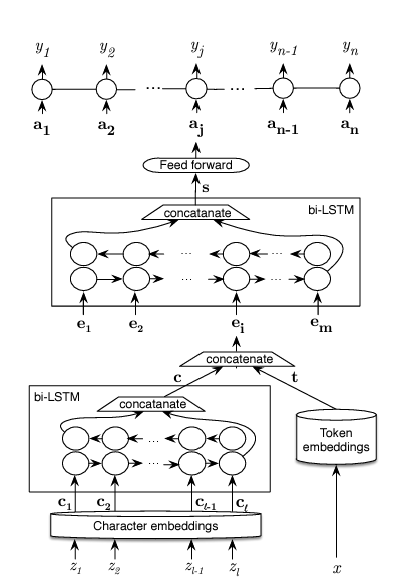

https://arxiv.org/pdf/1612.05251.pdf

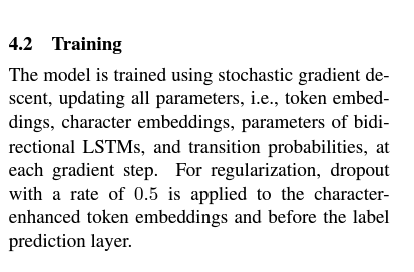

Create a token-level model (similar to model_1)
Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
Combine (using layers.Concatenate) the outputs of 1 and 2
Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification

The dropout layer is a regularization technique commonly used in neural networks to prevent overfitting. Overfitting occurs when a model learns to perform well on the training data but fails to generalize to new, unseen data. Dropout is designed to address this issue by randomly "dropping out" (i.e., setting to zero) a fraction of the units or neurons in a layer during training.

Here's how the dropout layer works:

Randomly "Dropping Out" Units:

During each training iteration, a dropout layer randomly sets a fraction of its input units to zero. This fraction is specified by the dropout rate, which is a hyperparameter typically set between 0 and 1.
For example, with a dropout rate of 0.5, the layer will, on average, set half of its input units to zero during each training iteration.
Preventing Co-Adaptation of Neurons:

By randomly dropping out units, the model becomes less sensitive to the specific weights of individual neurons. This prevents neurons from becoming overly specialized or co-adapting to each other during training.
The goal is to encourage the network to learn more robust features and reduce reliance on specific pathways through the network.
Ensemble Effect:

Dropout can be seen as training an ensemble of multiple models. In each training iteration, a different subset of neurons is active, effectively creating a diverse set of sub-networks.
During testing or inference, dropout is typically turned off, and the full network is used. However, the learned weights are scaled to account for the fact that, on average, only a fraction of the neurons were active during training.

In [83]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [84]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

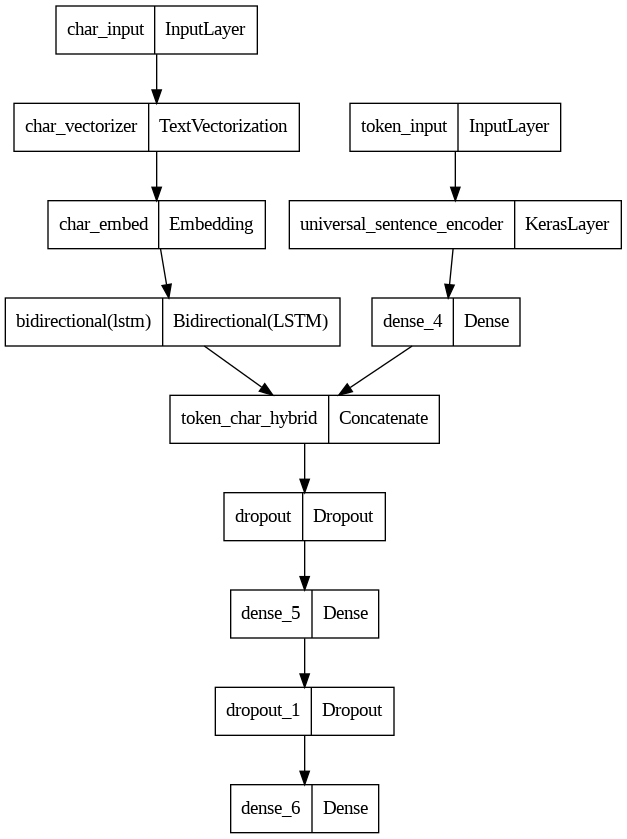

In [85]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

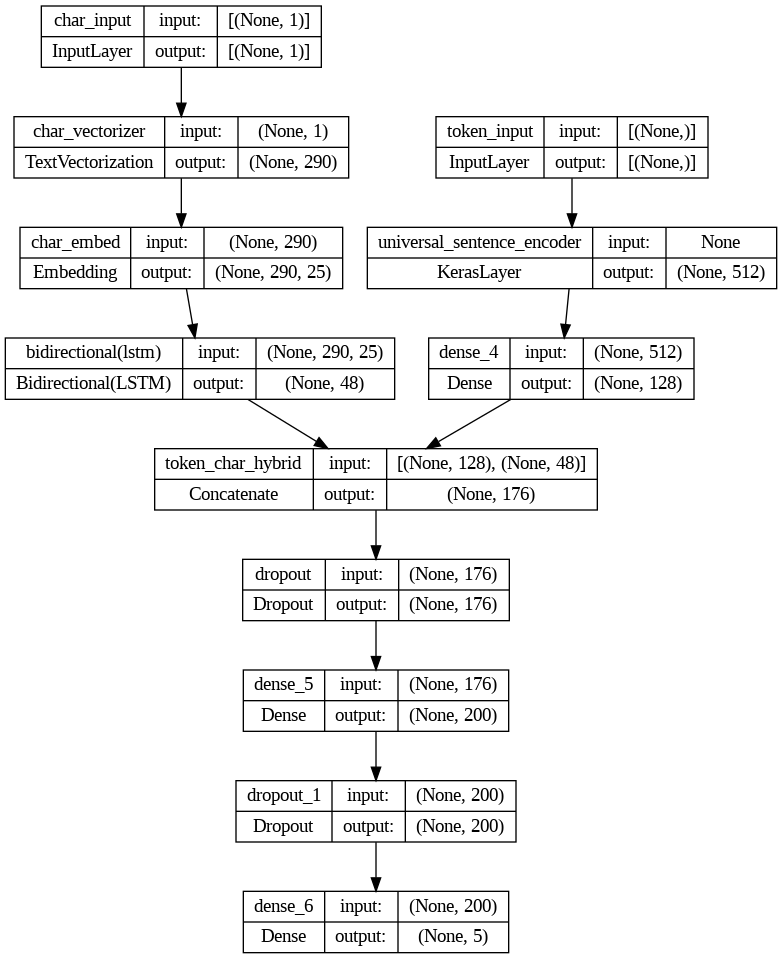

In [86]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Assuming you have defined and compiled your model before this code snippet

# Save the model plot to a file
plot_model(model_4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Display the saved plot
Image("model_plot.png")


In [87]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

And again, to keep our experiments fast, we'll fit our token-character-hybrid model on 10% of training and validate on 10% of validation batches. However, the difference with this model is that it requires two inputs, token-level sequences and character-level sequences.

We can do this by create a tf.data.Dataset with a tuple as it's first input, for example:

((token_data, char_data), (label))

In [88]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [89]:

# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [90]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 26s 36ms/step - loss: 0.9631 - accuracy: 0.6219 - val_loss: 0.7826 - val_accuracy: 0.6975
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 0.7969 - accuracy: 0.6929 - val_loss: 0.7161 - val_accuracy: 0.7254
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.7740 - accuracy: 0.7058 - val_loss: 0.6894 - val_accuracy: 0.7377


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

In [ ]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds


In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results


if you see the hybrid preteined and custom emebedding layer the latter perform wells. Maybe something else is also included. If refer the paper : 3.1.3, the order of how the sentences is in order  really played a crucil role as it is Lable sequential optimisation. but this is kind of feature engineering.

The "line_number" and "total_lines" columns are features which didn't necessarily come with the training data but can be passed to our model as a positional embedding. In other words, the positional embedding is where the sentence appears in an abstract.

# Create positional embeddings

ince our "line_number" and "total_line" columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with "line_number"=5 is five times greater than a line with "line_number"=1, we'll use one-hot-encoding to encode our "line_number" and "total_lines" features.

To do this, we can use the tf.one_hot utility.

tf.one_hot returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the depth parameter determines the dimension of the returned tensor.

To figure out what we should set the depth parameter to, let's investigate the distribution of the "line_number" column.

In [ ]:
train_df.line_number.plot.hist()

most of the abstract have lines from 0 to 15, thus we will one hot encode those.

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

so total number of lines most of it 20 so we can one hot encode at 20

In [ ]:

# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)


#Buliding the 5th Model with token embedding + cgharachter embedding+ postion feature engineeing

More specifically we're going to go through the following steps:

Create a token-level model (similar to model_1)
Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification

In [ ]:

# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
model_5.summary()

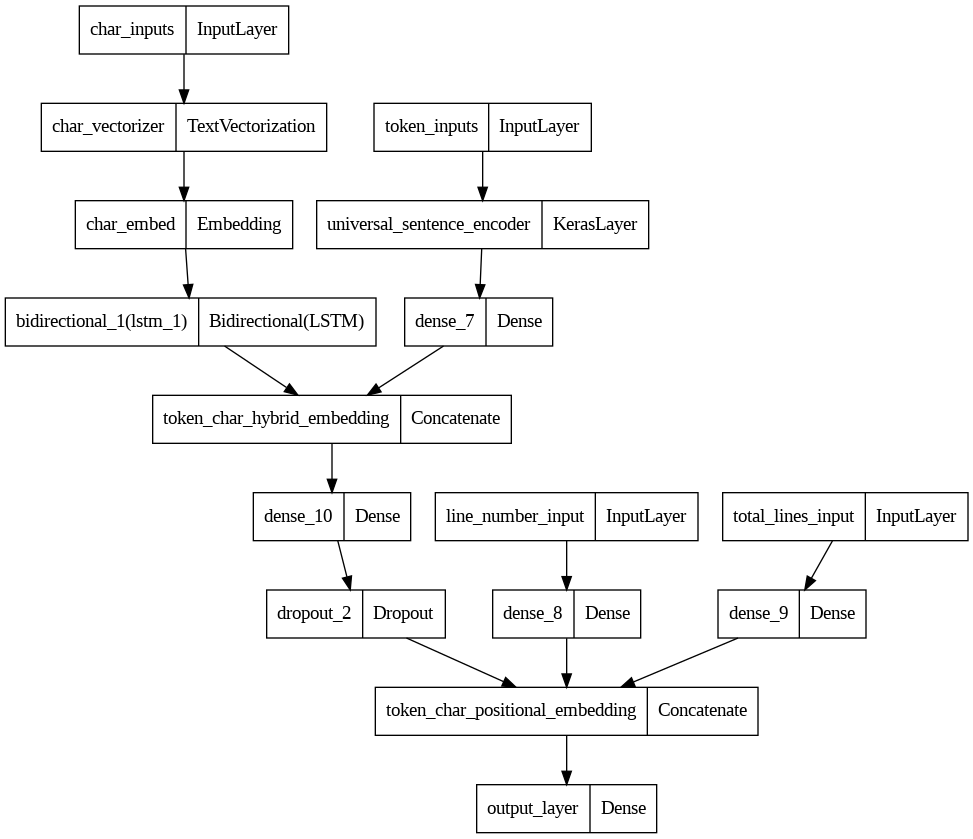

In [102]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:

# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

inputting the data by slicing as we have feature engineeered as well we have tot include that as well in the train,Val,Test data

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset


In [105]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 29s 41ms/step - loss: 1.0967 - accuracy: 0.7251 - val_loss: 0.9874 - val_accuracy: 0.7989
Epoch 2/3
562/562 [==============================] - 22s 38ms/step - loss: 0.9676 - accuracy: 0.8154 - val_loss: 0.9501 - val_accuracy: 0.8238
Epoch 3/3
562/562 [==============================] - 22s 38ms/step - loss: 0.9501 - accuracy: 0.8236 - val_loss: 0.9412 - val_accuracy: 0.8291


In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

In [ ]:
#all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# testing the model


In [140]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model")

In [141]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2024-01-14 12:02:17--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  55.3MB/s    in 16s     

2024-01-14 12:02:33 (59.1 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/sk

In [143]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#,
                                          # Note: with TensorFlow 2.5+ if your SavedModel has a keras_metadata.pb file
                                          # (created when using model.save()), you shouldn't need the custom_objects
                                          # parameter. I'm leaving the code below here in case you do.
                                          # custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                          #                 "KerasLayer": hub.KerasLayer}) # required for token embedding

In [145]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [146]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 23s 23ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 4, 0])>

In [147]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.58503401360544,
 'precision': 0.8242675229438334,
 'recall': 0.8258503401360544,
 'f1': 0.8246597603518342}

#Model_Bert

### TextVectorization

In [110]:
from tensorflow.keras.layers import TextVectorization, Embedding

sent_len = round(sum([len(i.split()) for i in train_sentences])/ len(train_sentences))
sent_len

26

In [111]:
max_vocab_length = 68000
max_length = 55

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=max_length,
)

In [112]:
max_vocab_length = 68000
max_length = 55

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=max_length,
)

text_vectorizer.adapt(train_sentences)

# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Embedding

In [113]:
embedding = Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 128,
    name='token_embedding'

)

### Positional Embedding

In [114]:
def split_character(text):
  return ' '.join(list(text))

In [115]:
train_chars = [split_character(sentences) for sentences in train_sentences]
val_chars = [split_character(sentences) for sentences in val_sentences]
test_chars = [split_character(sentences) for sentences in test_sentences]

In [116]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [117]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

NUM_CHAR_TOKEN = len(alphabet) + 2

char_vectorizer = TextVectorization(
    max_tokens = NUM_CHAR_TOKEN,
    output_sequence_length = output_seq_char_len,
)

char_vectorizer.adapt(train_chars)

char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


### Character Embedding

In [118]:
char_embedding = Embedding(
    input_dim = len(char_vocab),
    output_dim = 25,
    name = 'char_embed'
)

In [119]:
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)


train_line_number_one_hot[:5], train_line_number_one_hot.shape


(<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [120]:
train_total_line_number_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_line_number_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_line_number_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)


train_total_line_number_one_hot[:5], train_line_number_one_hot.shape

(<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 15]))

In [121]:
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot, train_total_line_number_one_hot, train_sentences, train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))

train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [122]:
val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot, val_total_line_number_one_hot, val_sentences, val_chars))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels))

val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [123]:

test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot, test_total_line_number_one_hot, test_sentences, test_chars))
test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_tribrid_labels))

test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [124]:
! pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 23.0 MB/s eta 0:00:00


### loading Bert Model

In [125]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert = hub.load('https://tfhub.dev/google/experts/bert/pubmed/2')

In [126]:
preprocess_layer = hub.KerasLayer(preprocess, name='bert_input_preprocess')
bert_layer = hub.KerasLayer(bert, name='bert_layer')

In [131]:
# 1. token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs', ragged=False)
bert_input = preprocess_layer(token_inputs)
bert_outputs = bert_layer(bert_input, training=False)
sequence_output = bert_outputs['pooled_output']
token_outputs = layers.Dense(128, activation='relu')(sequence_output)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Charater imputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input', ragged=False)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. model for line_number feature
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_numbers_input')
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

# 4. model for total_line feature
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_line_inputs')
total_lines_outputs = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

# 5. Concat layer 1 & 2
token_char_concat = layers.Concatenate(name='concat_layer')([token_model.output,
                                                             char_model.output])

# adding one dropout layer
z = layers.Dense(256, activation='relu')(token_char_concat)
z = layers.Dropout(0.5)(z)

# 6. concat layers 3 4 5
final_concat = layers.Concatenate(name='final_concat')([
    line_number_model.output,
    total_lines_model.output,
    z
])

# Output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(final_concat)

# final model
model_bert = tf.keras.Model(
    inputs = [
              line_number_model.input,
              total_lines_model.input,
              token_model.input,
              char_model.input,
    ],
    outputs = output_layer
)

In [132]:
model_bert.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 bert_input_preprocess (Ker  {'input_word_ids': (None,    0         ['token_inputs[0][0]']        
 asLayer)                    128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                         

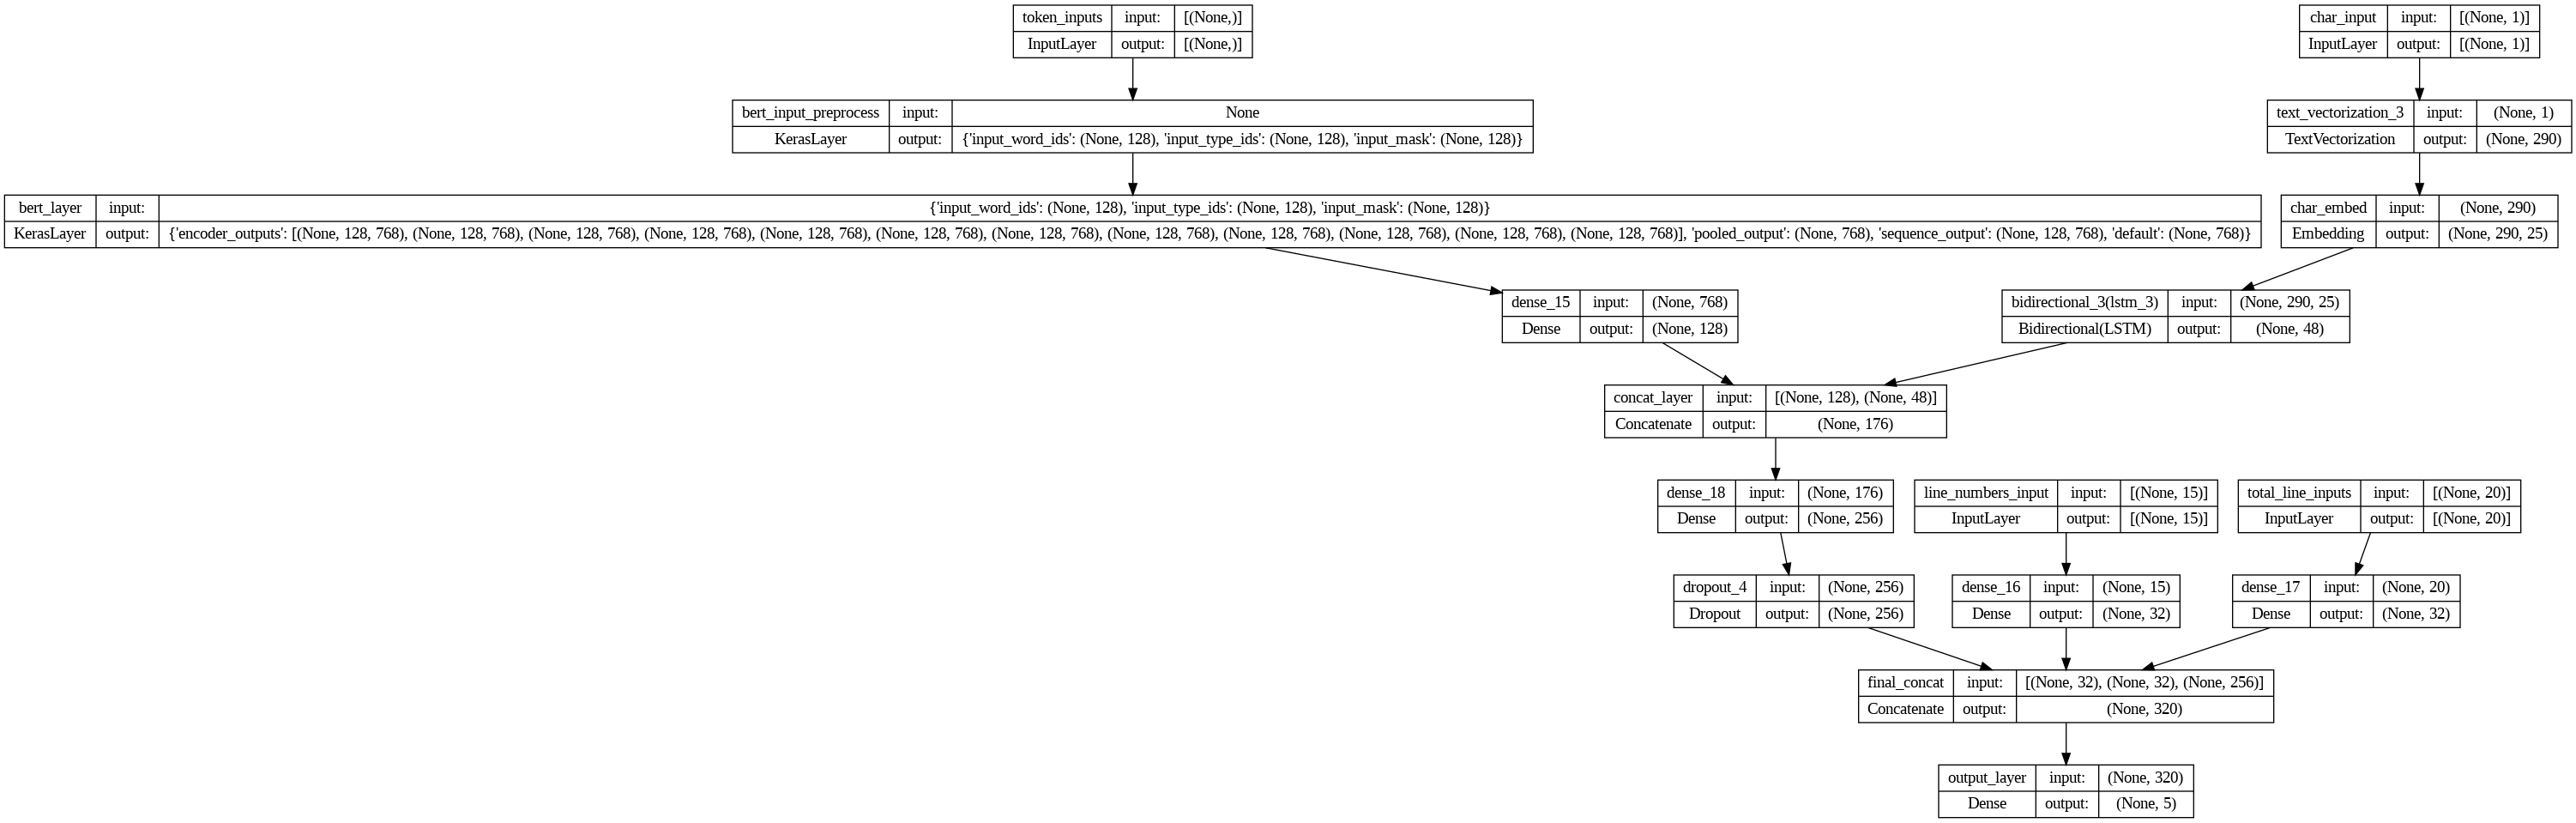

In [133]:
from tensorflow.keras.utils import plot_model
plot_model(model_bert, show_shapes=True)

In [134]:
model_bert.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy'],
)

In [135]:
history = model_bert.fit(
    train_tribrid_dataset,
    epochs = 3,
    steps_per_epoch = int(0.1 * len(train_tribrid_dataset)),
    validation_data = val_tribrid_dataset,
    validation_steps = int(0.1 * len(val_tribrid_dataset)),

)

Epoch 1/3
562/562 [==============================] - 261s 439ms/step - loss: 0.9796 - accuracy: 0.8119 - val_loss: 0.8959 - val_accuracy: 0.8620
Epoch 2/3
562/562 [==============================] - 244s 434ms/step - loss: 0.8978 - accuracy: 0.8640 - val_loss: 0.8687 - val_accuracy: 0.8770
Epoch 3/3
562/562 [==============================] - 244s 433ms/step - loss: 0.8819 - accuracy: 0.8746 - val_loss: 0.8572 - val_accuracy: 0.8807


In [136]:
model_bert_pred_probs = model_bert.predict(val_tribrid_dataset, verbose=1)
model_bert_preds = tf.argmax(model_bert_pred_probs, axis=1)

945/945 [==============================] - 327s 344ms/step


In [137]:
# Calculate results of token-char-positional hybrid model
model_bert_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_bert_preds)
model_bert_results

{'accuracy': 88.2000529590891,
 'precision': 0.8811306362972944,
 'recall': 0.882000529590891,
 'f1': 0.8812316716550652}

In [159]:
test_abstract_pred_probs = model_bert.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 2s 2s/step


array([[0.2617677 , 0.04166462, 0.04834697, 0.6170308 , 0.03118987],
       [0.06228096, 0.02545935, 0.7953296 , 0.08689368, 0.03003638],
       [0.09490883, 0.03883548, 0.6862353 , 0.09700168, 0.08301862],
       [0.08440948, 0.08743539, 0.6559734 , 0.06711286, 0.10506894],
       [0.02793815, 0.02713617, 0.02878181, 0.03352276, 0.88262117],
       [0.02199383, 0.04245171, 0.04766513, 0.03291807, 0.8549713 ],
       [0.0196653 , 0.06197003, 0.04776141, 0.02567289, 0.84493035],
       [0.01265958, 0.03799475, 0.0296536 , 0.02237575, 0.8973163 ]],
      dtype=float32)

In [160]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 4])>

In [161]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS']

In [162]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")


OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
RESULTS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


# Performance of Models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results,
                                  "bert_model":model_bert_results})
all_model_results = all_model_results.transpose()
all_model_results
all_model_results["accuracy"] = all_model_results["accuracy"]/100

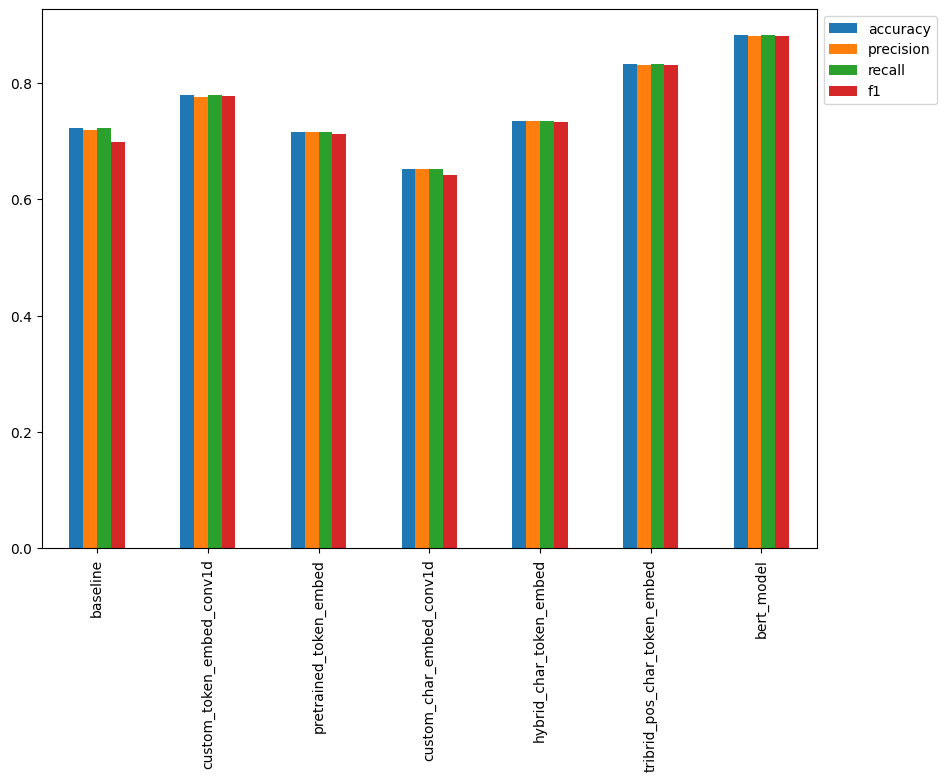

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

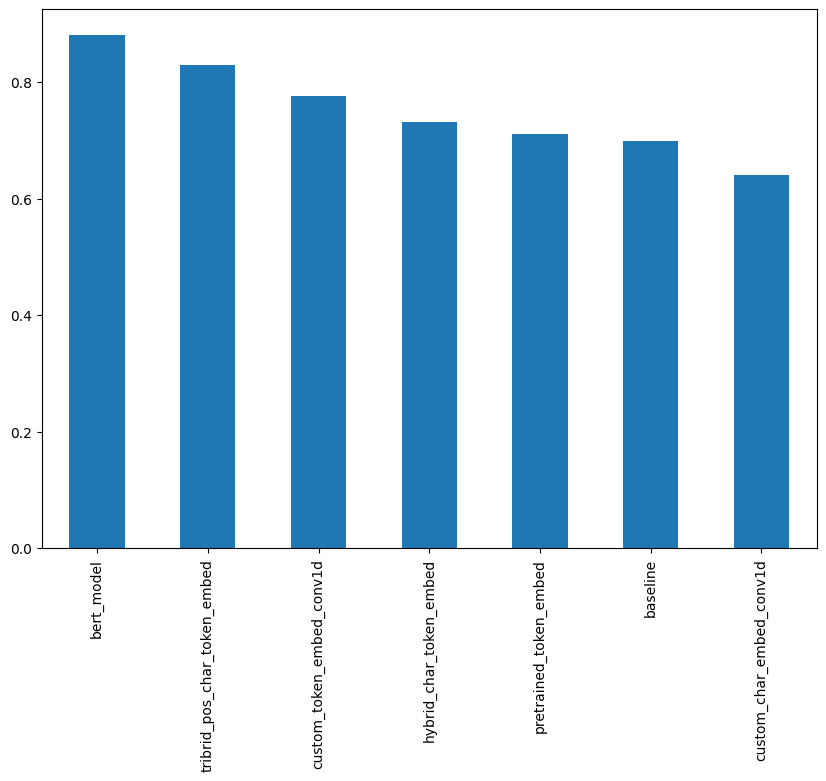

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

<ipython-input-165-aa99b437491f>:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=all_model_results.index, y="f1_percentage", data=all_model_results, marker='o', palette="viridis")


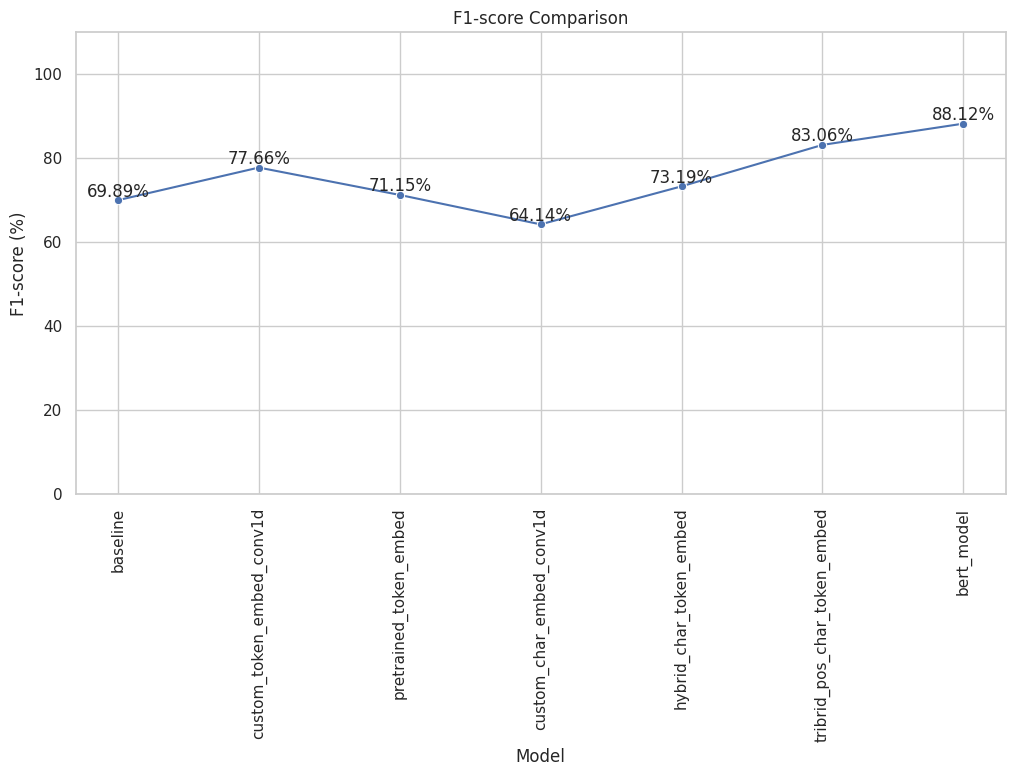

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming all_model_results is already defined with the F1-score values
# If not, replace it with the appropriate DataFrame

# Convert F1-score to percentage
all_model_results["f1_percentage"] = all_model_results["f1"] * 100

# Set the style of seaborn
sns.set(style="whitegrid")

# Plotting F1-score as a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=all_model_results.index, y="f1_percentage", data=all_model_results, marker='o', palette="viridis")
plt.title("F1-score Comparison")
plt.xlabel("Model")
plt.xticks(rotation = 90)
plt.ylabel("F1-score (%)")

# Annotate each point with the exact F1-score value
for i, value in enumerate(all_model_results["f1_percentage"]):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center')

plt.ylim(0, 110)  # Adjust the y-axis limits as needed
plt.show()


In [ ]:
from tabulate import tabulate

# Assuming all_model_results is already defined with accuracy, F1-score, recall, and precision values
# If not, replace it with the appropriate DataFrame

# Convert all values to percentage
all_model_results_percentage = all_model_results * 100

# Select relevant columns
table_data = all_model_results_percentage[["accuracy", "f1", "recall", "precision"]]

# Format the table
table_formatted = tabulate(table_data, headers='keys', tablefmt='pretty', showindex=True, floatfmt=(".2f", ".2f", ".2f", ".2f"))

print(table_formatted)


+------------------------------+-------------------+-------------------+-------------------+-------------------+
|                              |     accuracy      |        f1         |      recall       |     precision     |
+------------------------------+-------------------+-------------------+-------------------+-------------------+
|           baseline           | 72.1832384482987  | 69.89250353450294 | 72.1832384482987  | 71.86466952323352 |
|  custom_token_embed_conv1d   | 77.95577916059844 | 77.66485534148005 | 77.95577916059844 | 77.60299586924712 |
|    pretrained_token_embed    | 71.46167085926122 | 71.14540946776351 | 71.46167085926122 | 71.4694759834626  |
|   custom_char_embed_conv1d   | 65.11320005295909 | 64.13677213566176 | 65.11320005295909 | 65.23210193167186 |
|   hybrid_char_token_embed    | 73.42777704223488 | 73.1924272713637  | 73.42777704223488 | 73.45035828227753 |
| tribrid_pos_char_token_embed | 83.15900966503375 | 83.0577174100042  | 83.15900966503375 | 83.

# Make a sample prediction

In [ ]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-01-14 12:11:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-01-14 12:11:49 (63.6 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Old version of spaCy
# sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
# nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 1s 1s/step


array([[0.2644824 , 0.1105424 , 0.01762423, 0.5750657 , 0.03228523],
       [0.06927066, 0.03808296, 0.7078093 , 0.09543166, 0.08940545],
       [0.1377269 , 0.04937517, 0.5467969 , 0.1634129 , 0.10268808],
       [0.09659056, 0.17111638, 0.52574396, 0.07601641, 0.13053276],
       [0.04459697, 0.08888115, 0.4567545 , 0.04623033, 0.36353707],
       [0.03265214, 0.1462643 , 0.517485  , 0.04088319, 0.2627154 ],
       [0.03290154, 0.17796215, 0.07166825, 0.02870874, 0.6887593 ],
       [0.01843721, 0.13495174, 0.32084194, 0.03389723, 0.49187186]],
      dtype=float32)

In [ ]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [ ]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")


OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
